In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta 
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load Dataset

Make sure that training and validation set end at episode.

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul

In [7]:
#drop na columns 
all_df = all_df.dropna()

In [8]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [9]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [10]:
def getSensorReadingsOnlyNoEpisode(lst):
    result = []
    time = []
    for episode in lst:
        for row in episode:
            row_formatted = row[1:5]
            result.append(row_formatted)
            time.append(row[0])
    return (result, time)

In [11]:
#set random seed 
import tensorflow as tf
tf.random.set_seed(42)

In [12]:
train_arr, trainTime = getSensorReadingsOnlyNoEpisode(train_data)
val_arr, valTime = getSensorReadingsOnlyNoEpisode(val_data)
test_arr, testTime = getSensorReadingsOnlyNoEpisode(test_data)

In [13]:
train_arr

[[0.379151092, 0.556385187, 0.243079506, 0.229504293],
 [0.415506993, 0.698561103, 0.242410288, 0.273824561],
 [0.33934205, 0.637644818, 0.230266358, 0.191588098],
 [0.343817356, 0.627731997, 0.233904513, 0.264566349],
 [0.310361557, 0.607368113, 0.194295643, 0.240200195],
 [0.336327636, 0.531479142, 0.215693485, 0.215780325],
 [0.397831149, 0.57521239, 0.190585546, 0.230599092],
 [0.385974096, 0.630933953, 0.208516333, 0.247693397],
 [0.376943194, 0.396047283, 0.215659658, 0.256992779],
 [0.56498231, 0.648197926, 0.516587151, 0.256162471],
 [0.351867147, 0.647795783, 0.257161825, 0.276671218],
 [0.353867353, 0.615858294, 0.197009134, 0.269388231],
 [0.384169823, 0.622861995, 0.199791766, 0.305659257],
 [0.353154082, 0.597895409, 0.2172971, 0.265631153],
 [0.382126061, 0.655505276, 0.231748822, 0.258702261],
 [0.374770865, 0.676145451, 0.243662648, 0.259956326],
 [0.406003625, 0.626204276, 0.246397078, 0.26882794],
 [0.351261256, 0.265259177, 0.168831064, 0.441434541],
 [0.322982599, 0

In [14]:
def getStateValues(lst):
    stateList = []
    for episode in lst:
        for row in episode:
            stateValue = int(row[6])
            stateList.append(stateValue)
    return stateList

In [15]:
train_state = getStateValues(train_data)
val_state = getStateValues(val_data)
test_state = getStateValues(test_data)

In [17]:
def viewOutliers(clf):
    #training set
    y_train_scores = clf.decision_scores_
    plt.hist(y_train_scores, bins='auto') 
    plt.title("Histogram for training set anomaly scores")
    plt.show()
    
    #validation set
    y_val_scores = clf.decision_function(val_arr)  # outlier scores
    y_val_scores = pd.Series(y_val_scores)
    plt.hist(y_val_scores, bins='auto') 
    plt.title("Histogram for validation set anomaly scores")
    plt.show()

In [18]:
def getNormalSensorReadings(data_arr, stateList, stateThreshold):
    output = []
    for order in range(len(data_arr)):
        currentState = stateList[order]
        if currentState < stateThreshold: #threshold
            sensorArr = data_arr[order]
            output.append(sensorArr)
    return output

In [19]:
train_state

[0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 4,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 5,
 0,
 0,
 1,
 2,
 2,
 3,
 3,
 3,
 3,
 5,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 3,
 4,
 0,
 1,
 2,
 2,
 3,
 4,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 0,
 0,
 0,
 1,
 5,
 0,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 4,
 0,
 0,
 0,
 5,
 0,
 1,
 2,
 3,
 3,
 3,
 3,
 4,
 0,
 1,
 1,
 2,
 3,
 4,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 4,
 0,
 0,
 1,
 1,
 1,
 2,
 3,
 3,
 4,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 5,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 4,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 3,
 3,
 3,
 4,
 0,
 0,
 1,
 1,
 2,
 3,
 3,
 4,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 4,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 3,
 3,
 4,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 3,
 4,
 0,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 4,
 0,
 1,
 1,
 2,
 2,
 2,
 3,
 4,
 0,
 0,
 1,
 1,
 1,
 1,


In [23]:
trainNormal = getNormalSensorReadings(train_arr, train_state, 4)
len(trainNormal)

5509

In [25]:
trainValSplit = int(0.85*len(trainNormal))
trainNormal1 = trainNormal[:trainValSplit]
trainNormal2 = trainNormal[trainValSplit:]

In [29]:
trainNormal1_arr = np.array(trainNormal1)
trainNormal2_arr = np.array(trainNormal2)

In [30]:
trainNormal1_arr.shape

(4682, 4)

In [31]:
trainNormal2_arr.shape

(827, 4)

# Hyperparameter Tuning

### Number of dense layers

2 hidden layers 

In [26]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(1, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(3, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(4, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
 dense_1 (Dense)             (None, 2)                 8         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
 dense_3 (Dense)             (None, 2)                 4         
                                                                 
 dense_4 (Dense)             (None, 3)                 9         
                                                                 
 dense_5 (Dense)             (None, 4)                 16    

In [27]:
fileName1 = "AE_tuneLayers_2layer.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName1,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [28]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(metrics=[tf.keras.metrics.MeanSquaredError()],
                    loss='mean_squared_error',
                    optimizer=adam)

In [32]:
history = autoencoder.fit(trainNormal1_arr, trainNormal1_arr,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(trainNormal2_arr, trainNormal2_arr),
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                    ).history

Epoch 1/500
147/147 [==============================] - 9s 9ms/step - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 0.0839 - val_mean_squared_error: 0.0839
Epoch 2/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0618 - mean_squared_error: 0.0618 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 3/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 4/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 5/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 6/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 7/500
147/147 [=

147/147 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 52/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 53/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 54/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 55/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 56/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 57/500
147/147 [=======

147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 102/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 103/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 104/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 105/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 106/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 107/500
147/147 [=

Epoch 151/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 152/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 153/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 154/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 155/500
147/147 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 156/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 157/

Epoch 250/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 251/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 252/500
147/147 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 253/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 254/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 255/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 256/

Epoch 349/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 350/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 351/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 352/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 353/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 354/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 355/

Epoch 448/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 449/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 450/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 451/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 452/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 453/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 454/

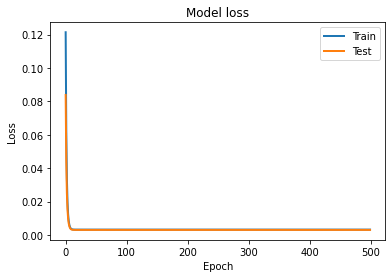

In [33]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [34]:
autoencoder = tf.keras.models.load_model("AE_tuneLayers_2layer.h5")

Determine Anomaly Threshold

In [35]:
def findFailureIndex(data):
    orderlist = []
    for order in range(len(data)):
        if data[order] > 3:
            orderlist.append(order)
    return orderlist

In [36]:
def findDegradeIndex(data): #includes state 3
    orderlist = []
    for order in range(len(data)):
        if data[order] > 2:
            orderlist.append(order)
    return orderlist

In [37]:
def getNormalIndex(data):
    orderlist = []
    for order in range(len(data)):
        if data[order] < 4:
            orderlist.append(order)
    return orderlist

In [38]:
def getValuebyIndex(data, indexList):
    output = []
    for order in indexList:
        output.append(data[order])
    return output

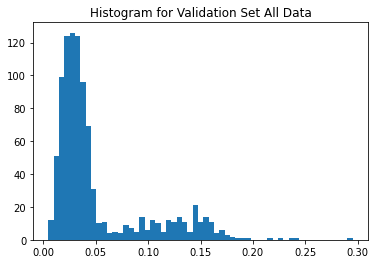

In [39]:
val_predictions = autoencoder.predict(val_arr)
val_score = (np.mean(np.power(val_arr - val_predictions, 2), axis=1))**0.5
plt.hist(val_score, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

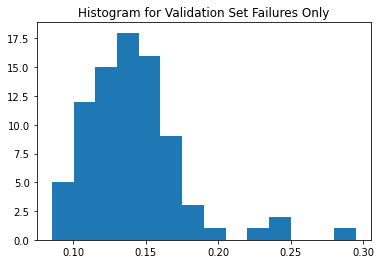

In [40]:
#find anomaly threshold by state
#failure data 
val_failureIndex = findFailureIndex(val_state)
val_failureScores = getValuebyIndex(val_score, val_failureIndex)
plt.hist(val_failureScores, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

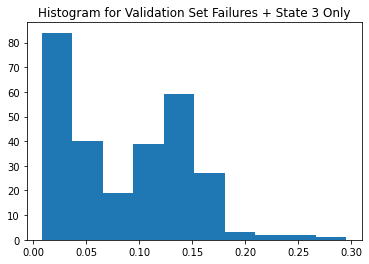

In [41]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex = findDegradeIndex(val_state)
val_degradationScores = getValuebyIndex(val_score, val_degradationIndex)
plt.hist(val_degradationScores, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

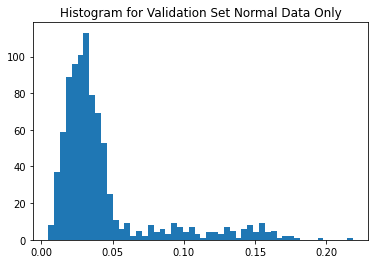

In [42]:
#normal data 
val_normalIndex = getNormalIndex(val_state)
val_normalScores = getValuebyIndex(val_score, val_normalIndex)
plt.hist(val_normalScores, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [44]:
import statistics
#find mean (validation)
valMean_normal = statistics.mean(val_normalScores)
valMean_normal

0.04262775356378404

In [45]:
#find standard deviation (validation)
valStdev_normal = statistics.stdev(val_normalScores)
valStdev_normal

0.035703427445835455

In [46]:
#1 standard deviation away 
valMean_normal + valStdev_normal

0.0783311810096195

In [47]:
#2 standard deviation away 
valMean_normal + valStdev_normal*2

0.11403460845545495

In [48]:
allValuesList = dataset.values.tolist()
allValuesList

[[0.0, 0.379151092, 0.556385187, 0.243079506, 0.229504293, 0.0],
 [1.0, 0.415506993, 0.698561103, 0.242410288, 0.273824561, 1.0],
 [2.0, 0.33934205, 0.637644818, 0.230266358, 0.191588098, 2.0],
 [3.0, 0.343817356, 0.627731997, 0.233904513, 0.264566349, 2.0],
 [4.0, 0.310361557, 0.607368113, 0.194295643, 0.240200195, 2.0],
 [5.0, 0.336327636, 0.531479142, 0.215693485, 0.215780325, 2.0],
 [6.0, 0.397831149, 0.57521239, 0.190585546, 0.230599092, 2.0],
 [7.0, 0.385974096, 0.630933953, 0.208516333, 0.247693397, 2.0],
 [8.0, 0.376943194, 0.396047283, 0.215659658, 0.256992779, 3.0],
 [9.0, 0.56498231, 0.648197926, 0.516587151, 0.256162471, 4.0],
 [10.0, 0.351867147, 0.647795783, 0.257161825, 0.276671218, 0.0],
 [11.0, 0.353867353, 0.615858294, 0.197009134, 0.269388231, 0.0],
 [12.0, 0.384169823, 0.622861995, 0.199791766, 0.305659257, 0.0],
 [13.0, 0.353154082, 0.597895409, 0.2172971, 0.265631153, 1.0],
 [14.0, 0.382126061, 0.655505276, 0.231748822, 0.258702261, 2.0],
 [15.0, 0.374770865, 0.67

In [52]:
def processAnomalyWithoutState3(anomalyScores, data, threshold, dataType):
    
    #initialise variables
    anomalousStateListTrain = []
    anomalousStatePreListTrain = []
    anomalousStatePostListTrain = []
    anomalousCountTrain = 0
    
    anomalousStateListVal = []
    anomalousStatePreListVal = []
    anomalousStatePostListVal = []
    anomalousCountVal = 0
    
    anomalousStateListTest = []
    anomalousStatePreListTest = []
    anomalousStatePostListTest = []
    anomalousCountTest = 0
    
    for order in range(0, len(anomalyScores)):
        score = anomalyScores[order]
        if score > threshold: #is anomaly
            reading = data[order]
            
            #process anomaly and count 
            anomalousIndex = 0
            for n in range(0, len(allValuesList)):
                row = allValuesList[n]
                if row[1:5] == reading: #is anomaly
                    anomalousIndex = n
                    if (dataType == 'Train'):
                        anomalousStateListTrain.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTrain.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTrain.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTrain =  anomalousCountTrain + 1
                    elif (dataType == 'Val'):
                        anomalousStateListVal.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListVal.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListVal.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountVal =  anomalousCountVal + 1
                    elif (dataType == 'Test'):
                        anomalousStateListTest.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTest.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTest.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTest =  anomalousCountTest + 1
                    break
        
    #graphical analysis 
    if (dataType == 'Train'):
        graphData = anomalousStateListTrain
    elif (dataType == 'Val'):
        graphData = anomalousStateListVal
    elif (dataType == 'Test'):
        graphData = anomalousStateListTest
        
    plt.hist(graphData, bins=[0,1,2,3,4,5,6])
    plt.title(f'Current anomalous state - {dataType}')
    plt.show()
    
    #numerical analysis 
    if (dataType == 'Train'):
        #training set
        train4count = anomalousStateListTrain.count(4.0)
        train5count = anomalousStateListTrain.count(5.0)
        train45count = train4count + train5count
        traintotalcount = len(anomalousStateListTrain)
        train4percent = train4count/traintotalcount
        train5percent = train5count/traintotalcount
        train45percent = train45count/traintotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in training set: %f" % train45percent)
        
        orgTrain4Count = train_state.count(4)
        orgTrain5Count = train_state.count(5)
        orgTrain45Count = orgTrain4Count + orgTrain5Count
        orgtrain4percent = train4count/orgTrain4Count
        orgtrain5percent = train5count/orgTrain5Count
        orgtrain45percent = train45count/orgTrain45Count
        print("Percentage of points in state 4 and 5 in training set identified as anomalies: %f" % orgtrain45percent)
    elif (dataType == 'Val'): #validation set
        val4count = anomalousStateListVal.count(4.0)
        val5count = anomalousStateListVal.count(5.0)
        val45count = val4count + val5count
        valtotalcount = len(anomalousStateListVal)
        val4percent = val4count/valtotalcount
        val5percent = val5count/valtotalcount
        val45percent = val45count/valtotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in validation set: %f" % val45percent)
        
        orgVal4Count = val_state.count(4)
        orgVal5Count = val_state.count(5)
        orgVal45Count = orgVal4Count + orgVal5Count
        orgVal4percent = val4count/orgVal4Count
        orgVal5percent = val5count/orgVal5Count
        orgVal45percent = val45count/orgVal45Count
        print("Percentage of points in state 4 and 5 in validation set identified as anomalies: %f" % orgVal45percent)
    elif (dataType == 'Test'): #test set
        test4count = anomalousStateListTest.count(4.0)
        test5count = anomalousStateListTest.count(5.0)
        test45count = test4count + test5count
        testtotalcount = len(anomalousStateListTest)
        test4percent = test4count/testtotalcount
        test5percent = test5count/testtotalcount
        test45percent = test45count/testtotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in test set: %f" % test45percent)
        
        orgTest4Count = test_state.count(4)
        orgTest5Count = test_state.count(5)
        orgTest45Count = orgTest4Count + orgTest5Count
        orgTest4percent = test4count/orgTest4Count
        orgTest5percent = test5count/orgTest5Count
        orgTest45percent = test45count/orgTest45Count
        print("Percentage of points in state 4 and 5 in test set identified as anomalies: %f" % orgTest45percent)

In [53]:
def processAnomalyWithState3(anomalyScores, data, threshold, dataType):
    
    #initialise variables
    anomalousStateListTrain = []
    anomalousStatePreListTrain = []
    anomalousStatePostListTrain = []
    anomalousCountTrain = 0
    
    anomalousStateListVal = []
    anomalousStatePreListVal = []
    anomalousStatePostListVal = []
    anomalousCountVal = 0
    
    anomalousStateListTest = []
    anomalousStatePreListTest = []
    anomalousStatePostListTest = []
    anomalousCountTest = 0
    
    for order in range(0, len(anomalyScores)):
        score = anomalyScores[order]
        if score > threshold: #is anomaly
            reading = data[order]
            
            #process anomaly and count 
            anomalousIndex = 0
            for n in range(0, len(allValuesList)):
                row = allValuesList[n]
                if row[1:5] == reading: #is anomaly
                    anomalousIndex = n
                    if (dataType == 'Train'):
                        anomalousStateListTrain.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTrain.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTrain.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTrain =  anomalousCountTrain + 1
                    elif (dataType == 'Val'):
                        anomalousStateListVal.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListVal.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListVal.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountVal =  anomalousCountVal + 1
                    elif (dataType == 'Test'):
                        anomalousStateListTest.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTest.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTest.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTest =  anomalousCountTest + 1
                    break
        
    #graphical analysis 
    if (dataType == 'Train'):
        graphData = anomalousStateListTrain
    elif (dataType == 'Val'):
        graphData = anomalousStateListVal
    elif (dataType == 'Test'):
        graphData = anomalousStateListTest
        
    plt.hist(graphData, bins=[0,1,2,3,4,5,6])
    plt.title(f'Current anomalous state - {dataType}')
    plt.show()
    
    #numerical analysis 
    if (dataType == 'Train'):
        #training set
        train3count = anomalousStateListTrain.count(3.0)
        train4count = anomalousStateListTrain.count(4.0)
        train5count = anomalousStateListTrain.count(5.0)
        train345count = train3count + train4count + train5count
        traintotalcount = len(anomalousStateListTrain)
        train345percent = train345count/traintotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in training set: %f" % train345percent)
        
        orgTrain3Count = train_state.count(3)
        orgTrain4Count = train_state.count(4)
        orgTrain5Count = train_state.count(5)
        orgTrain345Count = orgTrain3Count + orgTrain4Count + orgTrain5Count
        orgtrain345percent = train345count/orgTrain345Count
        print("Percentage of points in state 3, 4 and 5 in training set identified as anomalies: %f" % orgtrain345percent)
    elif (dataType == 'Val'): #validation set
        val3count = anomalousStateListVal.count(3.0)
        val4count = anomalousStateListVal.count(4.0)
        val5count = anomalousStateListVal.count(5.0)
        val345count = val3count + val4count + val5count
        valtotalcount = len(anomalousStateListVal)
        val345percent = val345count/valtotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: %f" % val345percent)
        
        orgVal3Count = val_state.count(3)
        orgVal4Count = val_state.count(4)
        orgVal5Count = val_state.count(5)
        orgVal345Count = orgVal3Count + orgVal4Count + orgVal5Count
        orgVal345percent = val345count/orgVal345Count
        print("Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: %f" % orgVal345percent)
    elif (dataType == 'Test'): #test set
        test3count = anomalousStateListTest.count(3.0)
        test4count = anomalousStateListTest.count(4.0)
        test5count = anomalousStateListTest.count(5.0)
        test345count = test3count + test4count + test5count
        testtotalcount = len(anomalousStateListTest)
        test345percent = test345count/testtotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in test set: %f" % test345percent)
        
        orgTest3Count = test_state.count(3)
        orgTest4Count = test_state.count(4)
        orgTest5Count = test_state.count(5)
        orgTest345Count = orgTest3Count + orgTest4Count + orgTest5Count
        orgTest345percent = test345count/orgTest345Count
        print("Percentage of points in state 3, 4 and 5 in test set identified as anomalies: %f \n" % orgTest345percent)

Current threshold value: 0.0583


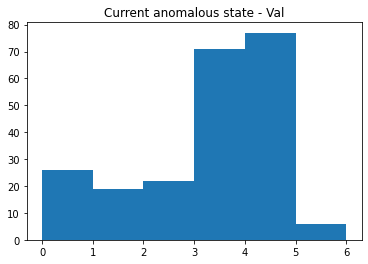

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.375566
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


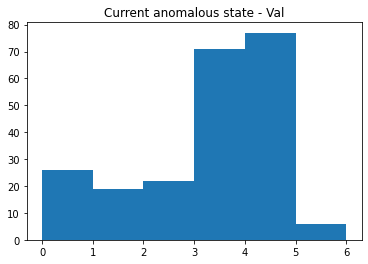

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.696833
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.557971
Current threshold value: 0.0683


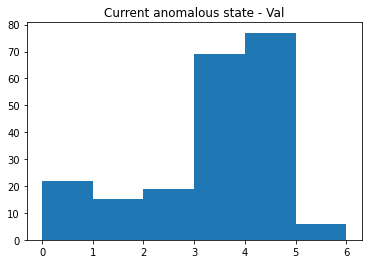

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.399038
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


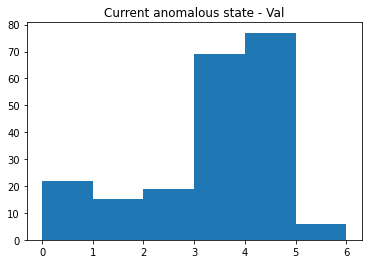

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.730769
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Current threshold value: 0.0783


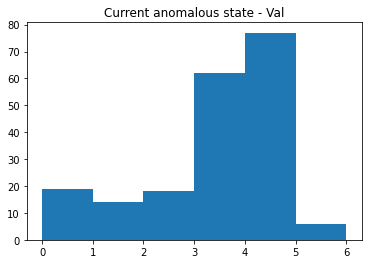

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.423469
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


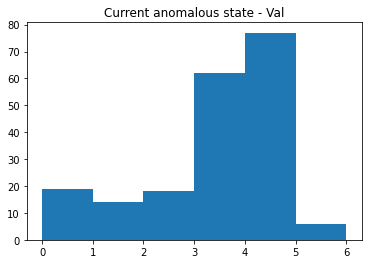

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.739796
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.525362
Current threshold value: 0.0883


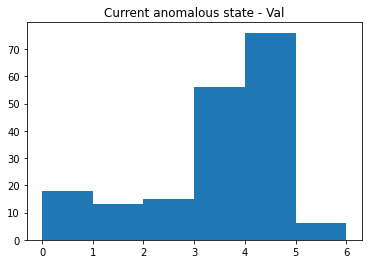

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.445652
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


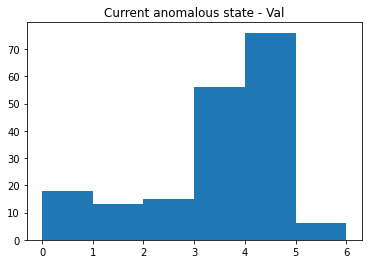

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.750000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000
Current threshold value: 0.0983


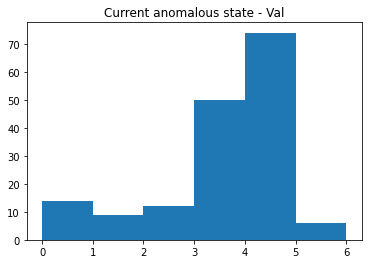

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.484848
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.963855


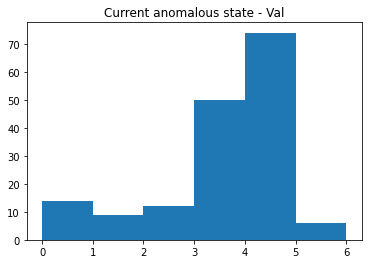

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.787879
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.471014


In [54]:
thresholdTest = [0.0583, 0.0683, 0.0783, 0.0883, 0.0983]
for value in thresholdTest:
    print('Current threshold value: %.4f' % value)
    processAnomalyWithoutState3(val_score, val_arr, value, 'Val')
    processAnomalyWithState3(val_score, val_arr, value, 'Val')

1 hidden layer

In [57]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(2, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(1, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(4, activation='tanh')(decoder)
#Autoencoder
autoencoder2 = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_10 (Dense)            (None, 2)                 10        
                                                                 
 dense_11 (Dense)            (None, 1)                 3         
                                                                 
 dense_12 (Dense)            (None, 2)                 4         
                                                                 
 dense_13 (Dense)            (None, 4)                 12        
                                                                 
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


In [58]:
fileName2 = "AE_tuneLayers_1layer.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName2,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [60]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder2.compile(metrics=[tf.keras.metrics.MeanSquaredError()],
                    loss='mean_squared_error',
                    optimizer=adam)

In [61]:
history2 = autoencoder2.fit(trainNormal1_arr, trainNormal1_arr,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(trainNormal2_arr, trainNormal2_arr),
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                    ).history

Epoch 1/500
147/147 [==============================] - 1s 6ms/step - loss: 0.1082 - mean_squared_error: 0.1082 - val_loss: 0.0530 - val_mean_squared_error: 0.0530
Epoch 2/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 3/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 6/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 7/500
147/147 [=

147/147 [==============================] - 1s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 52/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 53/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 54/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 55/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 56/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 57/500
147/147 [=======

147/147 [==============================] - 1s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 102/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 103/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 104/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 105/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 106/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 107/500
147/147 [=

Epoch 151/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 152/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 153/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 154/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 155/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 156/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 157/

Epoch 250/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 251/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 252/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 253/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 254/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 255/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 256/

Epoch 349/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 350/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 351/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 352/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 353/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 354/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 355/

Epoch 448/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 449/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 450/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 451/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 452/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 453/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 454/

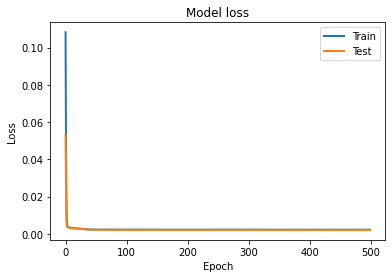

In [62]:
plt.plot(history2['loss'], linewidth=2, label='Train')
plt.plot(history2['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [63]:
autoencoder2 = tf.keras.models.load_model("AE_tuneLayers_1layer.h5")

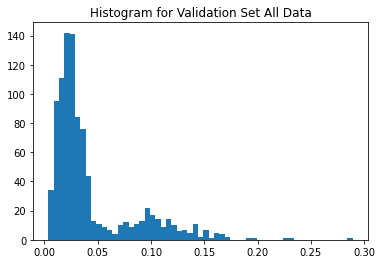

In [64]:
val_predictions2 = autoencoder2.predict(val_arr)
val_score2 = (np.mean(np.power(val_arr - val_predictions2, 2), axis=1))**0.5
plt.hist(val_score2, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

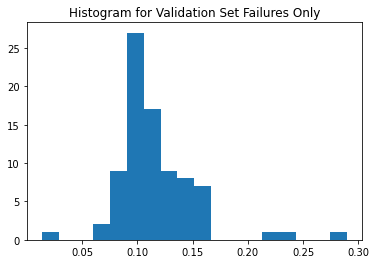

In [65]:
#find anomaly threshold by state
#failure data 
val_failureIndex2 = findFailureIndex(val_state)
val_failureScores2 = getValuebyIndex(val_score2, val_failureIndex2)
plt.hist(val_failureScores2, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

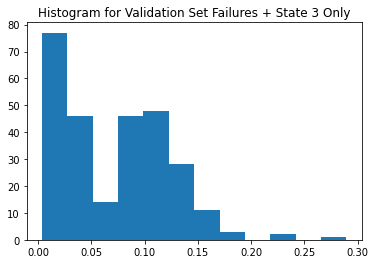

In [66]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex2 = findDegradeIndex(val_state)
val_degradationScores2 = getValuebyIndex(val_score2, val_degradationIndex2)
plt.hist(val_degradationScores2, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

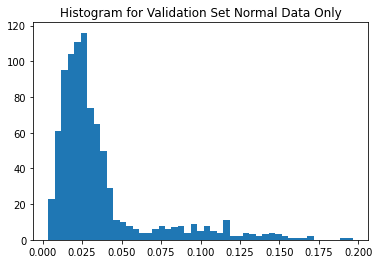

In [67]:
#normal data 
val_normalIndex2 = getNormalIndex(val_state)
val_normalScores2 = getValuebyIndex(val_score2, val_normalIndex2)
plt.hist(val_normalScores2, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [68]:
#find mean (validation)
valMean_normal2 = statistics.mean(val_normalScores2)
valMean_normal2

0.035898011428710845

In [69]:
#find standard deviation (validation)
valStdev_normal2 = statistics.stdev(val_normalScores2)
valStdev_normal2

0.03151474731169199

In [70]:
#1 standard deviation away 
valMean_normal2 + valStdev_normal2

0.06741275874040284

In [71]:
#2 standard deviation away 
valMean_normal2 + valStdev_normal2*2

0.09892750605209483

Current threshold value: 0.0274


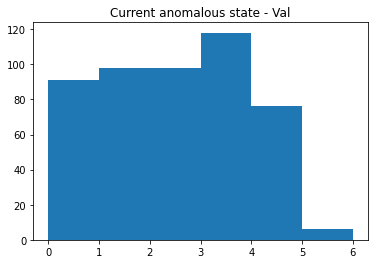

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.168378
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


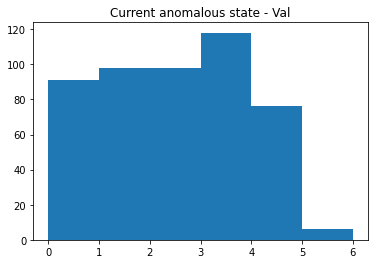

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.410678
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.724638
Current threshold value: 0.0374


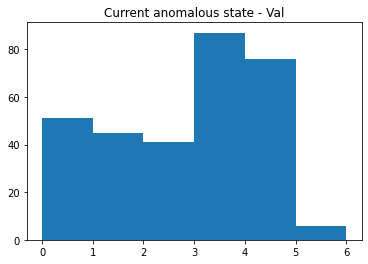

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.267974
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


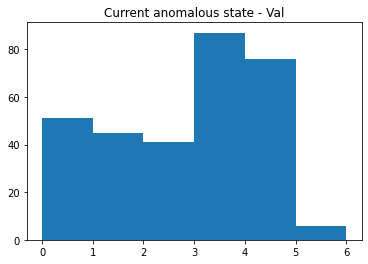

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.552288
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.612319
Current threshold value: 0.0474


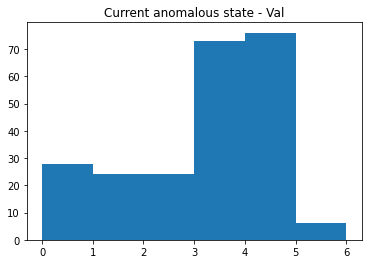

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.354978
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


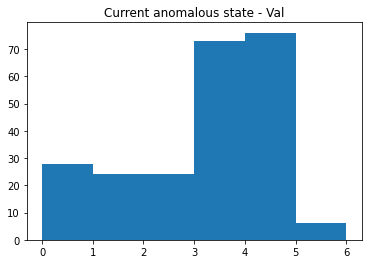

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.670996
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.561594
Current threshold value: 0.0574


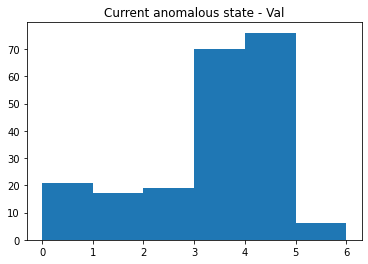

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.392344
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


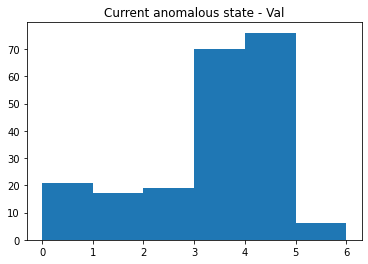

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.727273
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Current threshold value: 0.0674


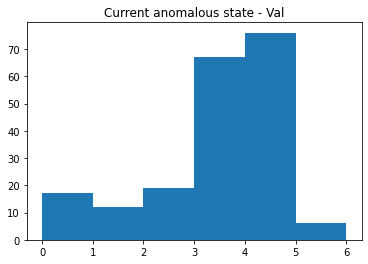

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.416244
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


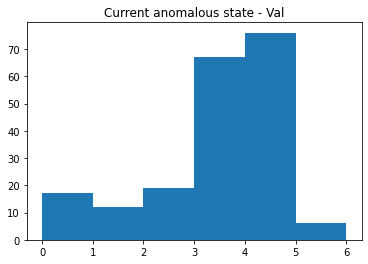

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.756345
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.539855
Current threshold value: 0.0774


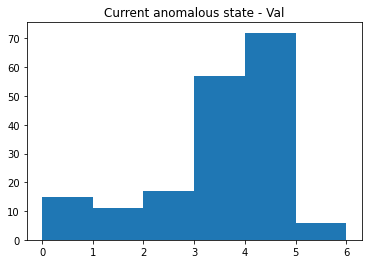

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.438202
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.939759


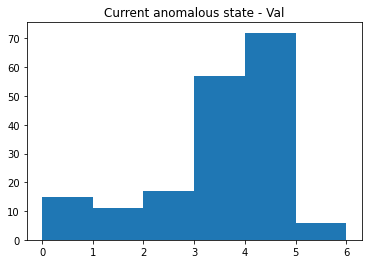

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.758427
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.489130
Current threshold value: 0.0874


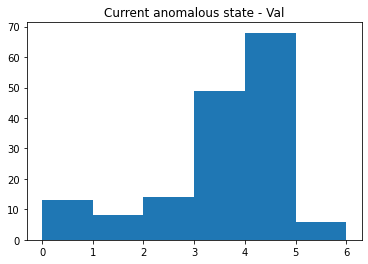

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.468354
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.891566


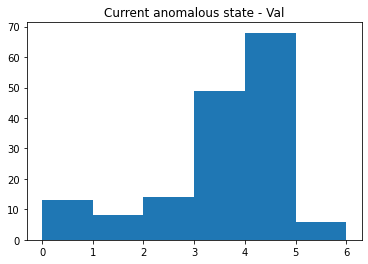

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.778481
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.445652


In [73]:
thresholdTest = [0.0274, 0.0374, 0.0474, 0.0574, 0.0674, 0.0774, 0.0874]
for value in thresholdTest:
    print('Current threshold value: %.4f' % value)
    processAnomalyWithoutState3(val_score2, val_arr, value, 'Val')
    processAnomalyWithState3(val_score2, val_arr, value, 'Val')

2 hidden layers seem to give better results